In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-future-sales/items.csv
/kaggle/input/predict-future-sales/sample_submission.csv
/kaggle/input/predict-future-sales/item_categories.csv
/kaggle/input/predict-future-sales/sales_train.csv
/kaggle/input/predict-future-sales/shops.csv
/kaggle/input/predict-future-sales/test.csv


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("atmadja/predict-future-sales")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/predict-future-sales


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [4]:
import pandas as pd

# Veriyi yükleyin
sales_train = pd.read_csv('/kaggle/input/predict-future-sales/sales_train.csv')

In [5]:
item_categories = pd.read_csv('../input/predict-future-sales/item_categories.csv')
items = pd.read_csv('../input/predict-future-sales/items.csv')
sales_train = pd.read_csv('../input/predict-future-sales/sales_train.csv')
test = pd.read_csv('../input/predict-future-sales/test.csv')
shops = pd.read_csv('../input/predict-future-sales/shops.csv')

In [6]:
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')

In [7]:
# Aylık satışları hesapla
sales_train['item_cnt_day'] = sales_train['item_cnt_day'].clip(0, 20)  # Outlier'ları düzelt
monthly_sales = sales_train.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg({
    'item_cnt_day': 'sum'
}).rename(columns={'item_cnt_day': 'item_cnt_month'})

In [8]:
# Test veri setiyle uyumlu hale getirmek için shop_id ve item_id'leri düzenle
test['date_block_num'] = 34  # Tahmin yapmak istediğimiz ay
merged_data = pd.concat([monthly_sales, test], axis=0, ignore_index=True).fillna(0)

In [9]:
# Veri setlerini birleştir
merged_data = merged_data.merge(items, on='item_id', how='left')
merged_data = merged_data.merge(item_categories, on='item_category_id', how='left')
merged_data = merged_data.merge(shops, on='shop_id', how='left')


In [10]:
print(merged_data.columns.tolist())


['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID', 'item_name', 'item_category_id', 'item_category_name', 'shop_name']


In [11]:
if 'item_category_id' not in merged_data.columns:
    merged_data['item_category_id'] = -1  # Varsayılan değer
if 'item_cnt_month' not in merged_data.columns:
    merged_data['item_cnt_month'] = 0.0  # Varsayılan değer


In [12]:
print(merged_data.columns.tolist())

['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID', 'item_name', 'item_category_id', 'item_category_name', 'shop_name']


In [13]:
# Veri türlerini küçült
merged_data['date_block_num'] = merged_data['date_block_num'].astype('int8')
merged_data['shop_id'] = merged_data['shop_id'].astype('int8')
merged_data['item_id'] = merged_data['item_id'].astype('int16')
merged_data['item_category_id'] = merged_data['item_category_id'].astype('int8')
merged_data['item_cnt_month'] = merged_data['item_cnt_month'].astype('float32')

In [14]:
# Alt küme oluşturma: Örneğin, yalnızca item_category_id == 40
filtered_data = merged_data[merged_data['item_category_id'] == 40]

In [15]:
# Veri setini yeniden eğitim ve test setlerine ayır
train_data = filtered_data[filtered_data['date_block_num'] < 33]
validation_data = filtered_data[filtered_data['date_block_num'] == 33]
test_data = filtered_data[filtered_data['date_block_num'] == 34]

In [16]:
# Modelleme için bağımlı ve bağımsız değişkenleri seç
X_train = train_data[['date_block_num', 'shop_id', 'item_id', 'item_category_id']]
y_train = train_data['item_cnt_month']

X_valid = validation_data[['date_block_num', 'shop_id', 'item_id', 'item_category_id']]
y_valid = validation_data['item_cnt_month']

X_test = test_data[['date_block_num', 'shop_id', 'item_id', 'item_category_id']]

In [17]:
from sklearn.linear_model import LinearRegression


In [18]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (331355, 4)
y_train shape: (331355,)


In [19]:
# Örnek veri seti
import pandas as pd

# Veri seti
data = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5],
    'feature2': [10, 20, 30, 40, 50],
    'target': [100, 200, 300, 400, 500]
})

# X ve y tanımlama
X = data[['feature1', 'feature2']]  # Özellik sütunları
y = data['target']  # Hedef sütunu


In [20]:
print(data.head())  # Veri setinin ilk 5 satırını görüntüle


   feature1  feature2  target
0         1        10     100
1         2        20     200
2         3        30     300
3         4        40     400
4         5        50     500


In [21]:
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (5, 2)
y shape: (5,)


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Veri seti
data = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5],
    'feature2': [10, 20, 30, 40, 50],
    'target': [100, 200, 300, 400, 500]
})

# X ve y tanımlama
X = data[['feature1', 'feature2']]
y = data['target']

# Eğitim ve test verisine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model oluşturma ve eğitme
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Tahmin yapma
predictions = linear_regressor.predict(X_test)
print("Predictions:", predictions)


Predictions: [200.]


In [24]:
print("Predictions:", predictions)


Predictions: [200.]


In [25]:
for i, pred in enumerate(predictions):
    print(f"Sample {i+1}: {pred}")


Sample 1: 199.9999999999999


In [26]:
import pandas as pd

# Tahminleri ve gerçek değerleri birleştir
results = pd.DataFrame({
    "Actual": y_test,
    "Predicted": predictions
})

print(results)


   Actual  Predicted
1     200      200.0


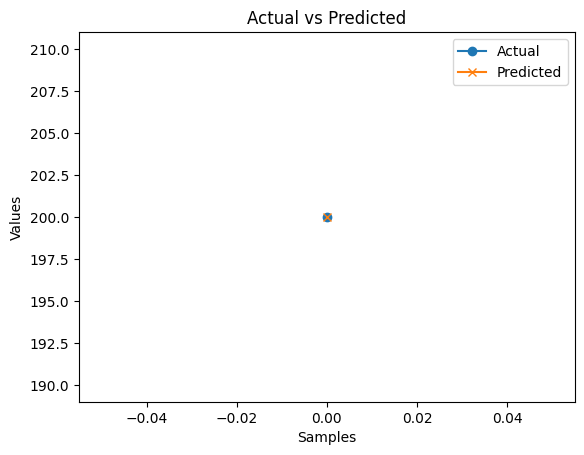

In [27]:
import matplotlib.pyplot as plt

# Gerçek ve tahmin edilen değerleri çiz
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(predictions, label="Predicted", marker='x')
plt.legend()
plt.title("Actual vs Predicted")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.show()


In [28]:
results.to_csv("predictions.csv", index=False)
print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv


In [29]:
new_data = [[2, 15]]  # Örnek: Yeni bir veri seti
single_prediction = linear_regressor.predict(new_data)
print("Prediction for new data:", single_prediction)


Prediction for new data: [150.4950495]


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
